In [10]:
# Import required libraries
import tweepy
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from datetime import datetime, timedelta
import tensorflow as tf

In [11]:
# Twitter API keys and access tokens
consumer_key = 'aUuTOXF4xuQaxHPoTj1SXs15y'
consumer_secret = 'VPWbSa7QtH3y1pFDiNruhzKZVwyFFZEEVIJx3IcyheFPpArvPU'
access_token = '943525676186869760-S9yLEmxBn6vZraC6boeSi258UJsRHtj'
access_token_secret = 'uOF58rEbsvV8AhKDUryl35IVJpZXxJwbWbvhRGhV7jTTR'

In [12]:
# Function to set up Twitter API
def create_api():
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth)
    return api

In [13]:
# Function to clean tweets
def clean_tweet(tweet):
    # Remove mentions, URLs, and non-alphanumeric characters
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

In [14]:
# Function to fetch tweets using Twitter API
def get_tweets(api, query, count=10000):
    tweets = []

    # Get the datetime for 5 hours ago
    since_datetime = datetime.now() - timedelta(hours=6)
    since_str = since_datetime.strftime("%Y-%m-%d")

    # Find a tweet from around 5 hours ago
    tweets_around_five_hours_ago = api.search_tweets(q=query, count=1, lang="en", tweet_mode="extended",
                                                     until=since_str)
    if tweets_around_five_hours_ago:
        since_id = tweets_around_five_hours_ago[0].id
    else:
        since_id = None

    # Use the since_id parameter to fetch tweets from the past 5 hours
    fetched_tweets = api.search_tweets(q=query, count=count, lang="en", tweet_mode="extended", since_id=since_id)

    # Clean and store fetched tweets
    for tweet in fetched_tweets:
        parsed_tweet = {'text': clean_tweet(tweet.full_text)}
        tweets.append(parsed_tweet)

    return tweets

In [15]:
# Function to load the pre-trained DistilBert model and tokenizer
def load_model():
    model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')
    return model, tokenizer

In [16]:
# Function to perform sentiment analysis
# Function to perform sentiment analysis
def sentiment_analysis(query):
    api = create_api()
    tweets = get_tweets(api, query)
    model, tokenizer = load_model()

    tweet_sentiments = {'positive': 0, 'negative': 0, 'neutral': 0}
    neutral_threshold = 0.05

    # Classify tweet sentiment using the model
    for tweet in tweets:
        inputs = tokenizer.encode_plus(tweet['text'], return_tensors='tf', padding=True, truncation=True)
        outputs = model(inputs)
        logits = outputs.logits.numpy()
        probs = tf.nn.softmax(logits, axis=1).numpy()[0]

        if probs[1] - probs[0] > neutral_threshold:
            tweet_sentiments['positive'] += 1
        elif probs[0] - probs[1] > neutral_threshold:
            tweet_sentiments['negative'] += 1
        else:
            tweet_sentiments['neutral'] += 1

    # Calculate sentiment percentages
    tweet_sentiments_percentages = {k: v / len(tweets) * 100 for k, v in tweet_sentiments.items()}

    # Print sentiment percentages
    print("Sentiment analysis for", query)
    for sentiment, percentage in tweet_sentiments_percentages.items():
        print(f"{sentiment.capitalize()}: {percentage:.2f}%")

    # Create a pie chart to visualize sentiment percentages
    plt.pie(tweet_sentiments_percentages.values(), labels=tweet_sentiments_percentages.keys(), autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title(f"Sentiment analysis for {query}")
    plt.show()

Enter the stock or crypto symbol:  bitcoin


Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Sentiment analysis for bitcoin
Positive: 34.94%
Negative: 65.06%
Neutral: 0.00%


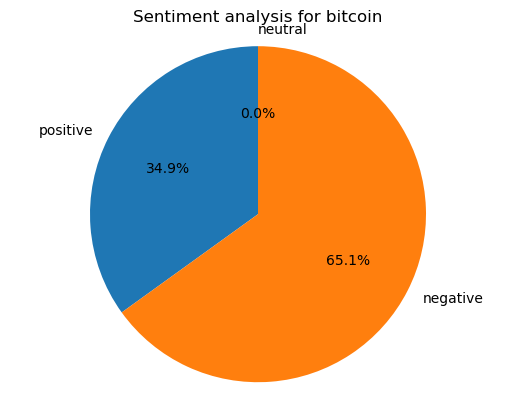

Note: This sentiment analysis might not accurately 
capture sarcasm or nuanced expressions of sentiment.


In [17]:
# Main function to take user input and call the sentiment_analysis function
if __name__ == "__main__":
    query = input("Enter the stock or crypto symbol: ")
    sentiment_analysis(query)
    print("Note: This sentiment analysis might not accurately \n"
          "capture sarcasm or nuanced expressions of sentiment.")